# lab

Laboratory tests that have have been mapped to a standard set of measurements. Unmapped measurements are recorded in the customLab table. The lab table is fairly well populated by hospitals. It is possible some rarely obtained lab measurements are not interfaced into the system and therefore will not be available in the database. Absence of a rare lab measurement, such as serum lidocaine concentrations, would not indicate the lab was not drawn. However, absence of a platelet count would likely indicate the value was not obtained.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [3]:
patientunitstayid = 2704494

In [4]:
query = query_schema + """
select *
from lab
where patientunitstayid = {}
order by labresultoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,patientunitstayid,labid,labresultyear,labresulttime24,labresulttime,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedyear,labresultrevisedtime24,labresultrevisedtime,labresultrevisedoffset
0,2704494,635381067,2014,00:05:00,midnight,-99620,1.0,sodium,136.00,136,mmol/L,mmol/L,2014,00:42:48,midnight,-99583
1,2704494,648998951,2014,00:05:00,midnight,-99620,3.0,-monos,6.00,6,%,%,2014,00:52:16,midnight,-99573
2,2704494,648998947,2014,00:05:00,midnight,-99620,3.0,Hgb,9.60,9.6,g/dL,g/dL,2014,00:52:10,midnight,-99573
3,2704494,648998952,2014,00:05:00,midnight,-99620,3.0,MCHC,34.30,34.3,g/dL,g/dL,2014,00:52:10,midnight,-99573
4,2704494,635381063,2014,00:05:00,midnight,-99620,1.0,creatinine,4.23,4.23,mg/dL,mg/dL,2014,00:42:48,midnight,-99583


In [5]:
query = query_schema + """
select *
from patient
where patientunitstayid = {}
""".format(patientunitstayid)

pt = pd.read_sql_query(query, con)
pt[['patientunitstayid', 'apacheadmissiondx', 'hospitaladmitoffset']]

,patientunitstayid,apacheadmissiondx,hospitaladmitoffset
0,2704494,Thrombocytopenia,-99779


Immediately we can note the very large negative `labresultoffset`. This likely means we have some lab values pre-ICU. In some cases this will be a lab measured in another hospital location such as the emergency department or hospital floor. In this case, the large value (-99620 minutes, or ~70 days) is surprising, but we can see from the patient table that the patient was admitted to the hospital -99779 minutes before their ICU stay (`hospitaladmitoffset`). This patient was admitted to the ICU with thrombocytopenia (`apacheadmissiondx`), and inspection of the diagnosis table indicates they have a form of cancer, so likely this is a long hospital stay where labs were taken on hospital admission.

## Available labs

We can group the lab table to summarize all available labs.

In [6]:
query = query_schema + """
select labname, count(*) as n
from lab
group by labname
order by n desc
""".format(patientunitstayid)

lab = pd.read_sql_query(query, con)
print('{} total vlues for {} distinct labs.'.format(lab['n'].sum(), lab.shape[0]))
print('\nTop 5 labs by frequency:')
lab.head()

39132531 total vlues for 158 distinct labs.

Top 5 labs by frequency:


,labname,n
0,bedside glucose,3175835
1,potassium,1493261
2,sodium,1393205
3,glucose,1319496
4,Hgb,1298708


The lab table is a large table with over 39 million observations. The most frequent observation is bedside glucose which accounts for almost 10% of the lab table, followed by potassium and sodium.

## Hospitals with data available

In [7]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from lab
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6861,97.195070
54,167,6092,5897,96.799081
106,264,5237,5075,96.906626
184,420,4679,4603,98.375721
58,176,4328,4254,98.290203
134,338,4277,4237,99.064765
71,199,4240,4122,97.216981
90,243,4243,4104,96.724016
206,458,3701,3643,98.432856
200,443,3656,3614,98.851204


In [8]:
df.tail(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
18,91,15,14,93.333333
45,151,14,13,92.857143
138,351,27,13,48.148148
16,86,15,12,80.000000
129,323,11,11,100.000000
146,361,13,10,76.923077
21,94,9,9,100.000000
154,385,3,3,100.000000
36,136,3,2,66.666667
176,409,33,0,0.000000


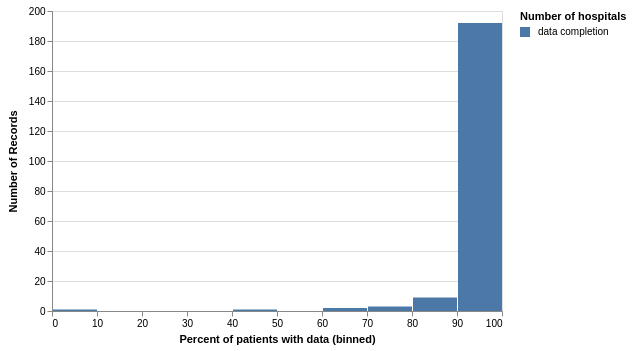

In [9]:
df[['data completion']].vgplot.hist(bins=10,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

Above we can see that very few hospitals are missing lab data. Most of the data at < 90% data completion is driven by a few hospitals with very few patients. The majority of hospitals have 90-100% of patients with data in the lab table (right side of histogram, 0-90% bin).